In [1]:
# need to install ultralytics for YOLO architecture
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 591.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.1/871.1 kB 10.5 MB/s eta 0:00:00


In [15]:
# setup chunk, import all necessary libraries

from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from torchvision import transforms
import torch.nn.functional as F
from datetime import datetime
import random
import math
import csv
import pandas as pd

### Importing YOLO Model
We import the YOLO model we fine-tuned on the Oxford Street Dataset. This fine-tuning was done in order to let the model learn from images that are pretty similar to the surveillance data we are using in the analysis.

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/deeplearningproject/best.pt'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define paths kaggle
folder_paths = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewYork_filtered',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewOrleans_filtered',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/London_filtered'
}

# import the YOLO model
yolo = YOLO("/kaggle/input/deeplearningproject/best.pt", verbose = False)

In [25]:
# define paths google drive
folder_paths = {
    'New York': '/content/drive/My Drive/Filtered_Images/NewYork_filtered',
    'New Orleans': '/content/drive/My Drive/Filtered_Images/NewOrleans_filtered',
    'London': '/content/drive/My Drive/Filtered_Images/London_filtered'
}


# import the YOLO model
yolo = YOLO("/content/drive/My Drive/YOLO_model/best.pt", verbose = False)

YOLO is designed to predict bounding boxes around people. Since we are merely interested in the number of people on an image we define a function that counts all bounding boxes for people that the model outputs.

In [26]:
def count_people_from_yolo(image_path, model):
    # get the model results
    results = model(image_path, verbose = False)

    # results is a list so we need to index its first element
    detections = results[0]

    # extract bounding boxes and class IDs
    class_ids = detections.boxes.cls.cpu().numpy()

    # count the number of people detected by counting the number of class IDs for person class
    person_count = sum(class_id == 0 for class_id in class_ids)

    return person_count

### Testing Model on Earthcam Images
Next, we apply the YOLO model to the Earthcam images we collected for London, New York and New Orleans. After defining the folder paths where the surveillance images are located, a preprocessing object is defined that converts the images into tensor objects and normalizes them in the same way as the training data used to train the CNN. To test the performance of the model, we visualize some example images with the corresponding predicted number of people that the model has output.

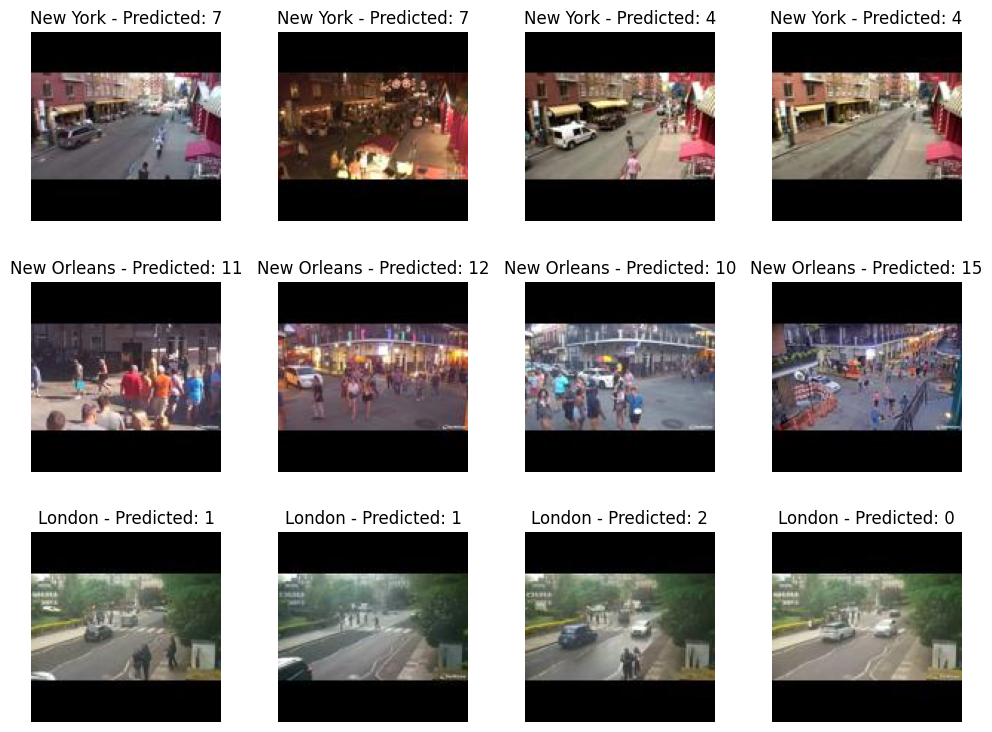

In [9]:
# visualize how model works on the images

# visualize how model works on the images
def visualize_prediction(model, year, number_of_images_per_city=2):

    all_image_files = [] # empty list where images to visualize are stored

    # loop through all image filenames in each directory
    for city, image_dir in folder_paths.items():
        city_image_files = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                parts = filename.split('_')
                date = parts[1]
                file_year = date.split('-')[-1]
                if file_year == year:
                    city_image_files.append((city, filename))

        # randomly select the specified number of images for this city
        selected_images = random.sample(city_image_files, number_of_images_per_city)
        all_image_files.extend(selected_images)

    # calculate the number of rows and columns based on the total number of images to visualize
    total_images = len(all_image_files)
    rows = math.ceil(total_images / 4)
    cols = min(4, total_images)

    # create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # loop through the list with all image files
    for i, (city, filename) in enumerate(all_image_files):
        image_dir = folder_paths[city]
        image_path = os.path.join(image_dir, filename)

        # load and preprocess the image
        image = Image.open(image_path).convert('RGB')

        # predict using the model
        predicted_count = count_people_from_yolo(image_path, model)

        # determine the correct axis for single or multiple rows/columns
        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        # display the image with title showing city and predicted count
        ax.imshow(image)
        ax.set_title(f"{city} - Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# visualize the prediction for images from each city
visualize_prediction(yolo, "2019", number_of_images_per_city=4)

### Main Analysis
Now that we have seen how the model works in different situations, we come to the main part of the analysis. Here we predict the number of people for all the images we have collected for all three cities. Next, we take the average of the individual days per city per year. This is to model a trend of how the number of people has evolved over time. By calculating the mean value, we want to minimize the problem that the images were taken at very different times of day and do not always show exactly the same camera angle. Averaging over the number of images should therefore make our results more robust to this randomness.

In [10]:
# create a dictionary storing all cities, years and dates to store counts there
results = {
    "London": {
        "2019": {"05-01-2019": [], "05-02-2019": [], "05-03-2019": [], "05-04-2019": [],
                 "05-05-2019": [], "05-06-2019": [], "05-07-2019": [], "05-08-2019": [],
                 "05-09-2019": [], "05-10-2019": [], "05-11-2019": [], "05-12-2019": [],
                 "05-13-2019": [], "05-14-2019": []},
        "2020": {"05-01-2020": [], "05-02-2020": [], "05-03-2020": [], "05-04-2020": [],
                 "05-05-2020": [], "05-06-2020": [], "05-07-2020": [], "05-08-2020": [],
                 "05-09-2020": [], "05-10-2020": [], "05-11-2020": [], "05-12-2020": [],
                 "05-13-2020": [], "05-14-2020": []},
        "2022": {"05-01-2022": [], "05-02-2022": [], "05-03-2022": [], "05-04-2022": [],
                 "05-05-2022": [], "05-06-2022": [], "05-07-2022": [], "05-08-2022": [],
                 "05-09-2022": [], "05-10-2022": [], "05-11-2022": [], "05-12-2022": [],
                 "05-13-2022": [], "05-14-2022": []}
    },
    "New York": {
        "2019": {"06-16-2019": [], "06-17-2019": [], "06-18-2019": [], "06-19-2019": [],
                 "06-20-2019": [], "06-21-2019": [], "06-22-2019": [], "06-23-2019": [],
                 "06-24-2019": [], "06-25-2019": [], "06-26-2019": [], "06-27-2019": [],
                 "06-28-2019": [], "06-29-2019": []},
        "2020": {"06-16-2020": [], "06-17-2020": [], "06-18-2020": [], "06-19-2020": [],
                 "06-20-2020": [], "06-21-2020": [], "06-22-2020": [], "06-23-2020": [],
                 "06-24-2020": [], "06-25-2020": [], "06-26-2020": [], "06-27-2020": [],
                 "06-28-2020": [], "06-29-2020": []},
        "2022": {"06-16-2022": [], "06-17-2022": [], "06-18-2022": [], "06-19-2022": [],
                 "06-20-2022": [], "06-21-2022": [], "06-22-2022": [], "06-23-2022": [],
                 "06-24-2022": [], "06-25-2022": [], "06-26-2022": [], "06-27-2022": [],
                 "06-28-2022": [], "06-29-2022": []}
    },
    "New Orleans": {
        "2019": {"05-13-2019": [], "05-14-2019": [], "05-15-2019": [], "05-16-2019": [],
                 "05-17-2019": [], "05-18-2019": [], "05-19-2019": [], "05-20-2019": [],
                 "05-21-2019": [], "05-22-2019": [], "05-23-2019": [], "05-24-2019": [],
                 "05-25-2019": [], "05-26-2019": []},
        "2020": {"05-13-2020": [], "05-14-2020": [], "05-15-2020": [], "05-16-2020": [],
                 "05-17-2020": [], "05-18-2020": [], "05-19-2020": [], "05-20-2020": [],
                 "05-21-2020": [], "05-22-2020": [], "05-23-2020": [], "05-24-2020": [],
                 "05-25-2020": [], "05-26-2020": []},
        "2022": {"05-13-2022": [], "05-14-2022": [], "05-15-2022": [], "05-16-2022": [],
                 "05-17-2022": [], "05-18-2022": [], "05-19-2022": [], "05-20-2022": [],
                 "05-21-2022": [], "05-22-2022": [], "05-23-2022": [], "05-24-2022": [],
                 "05-25-2022": [], "05-26-2022": []}
    }
}

# loop through all city paths in the dictionary
for city, path in folder_paths.items():

    # loop through all images per image directory
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0] # get the city name
            date = parts[1] # get the date
            year = date.split('-')[-1] # get the year from the date

            # open the image
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert('RGB')

            # get the predicted count by applying the earlier defined function
            count = count_people_from_yolo(image_path, yolo)

            # store count in the dictionary
            if year in results[city]:
                results[city][year][date].append(count)

averages = {} # define empty dictionary to store average counts per day

# loop through all cities and years
for city, years in results.items():
    averages[city] = {} # store city in the averages dictionary
    for year, days in years.items(): # loop through years
        averages[city][year] = {} # store year in the averages dictionary
        for day, counts in days.items(): # loop through all days
            avg_count = sum(counts) / len(counts) # get the average count per day
            averages[city][year][day] = avg_count # store average day count in the averages dictionary

In a final step, we visualize our results in three graphs (one per city) that show the development of the average number of people counted per day. For each city, the graph shows the same two weeks in 2019, 2020 and 2022. The first week in 2020 corresponds to a period in which the city in question was in lockdown. In the second week of 2022, this lockdown was eased again. We have shaded the corresponding areas red for the lockdown and green for the period in which this lockdown has already been eased to a certain extent.

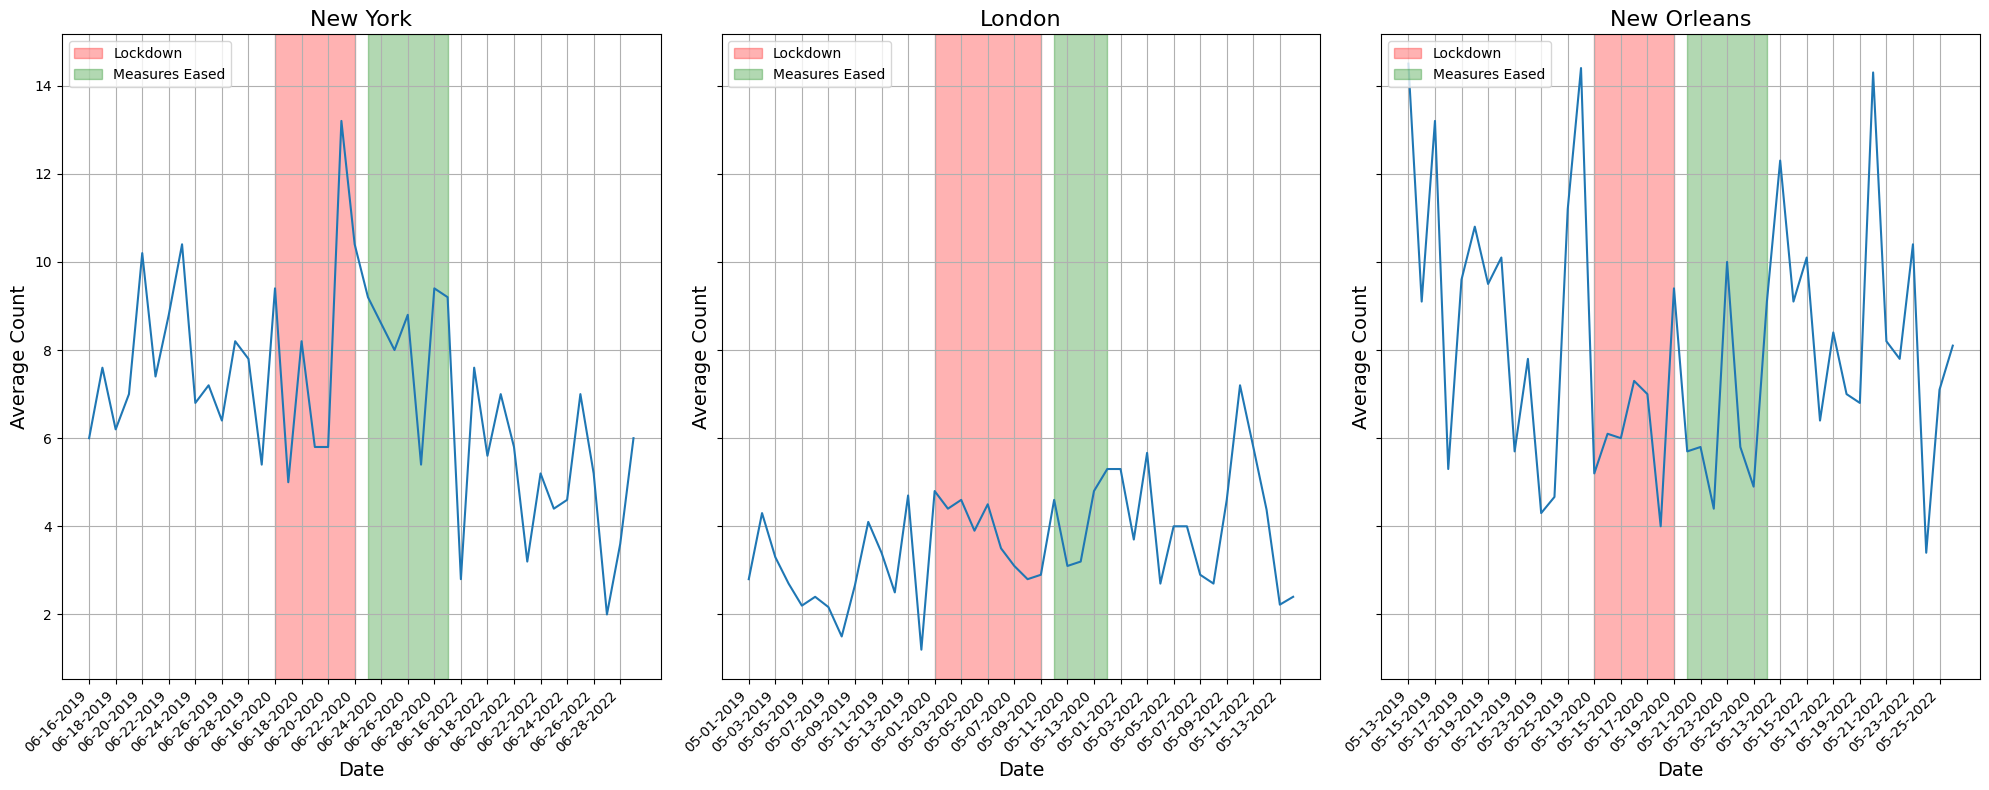

In [11]:
# function to flatten the averages dictionary for later visualization
def flatten_averages(averages):
    flattened = [] # define empty list to store the results
    # loop through all cities
    for city, years in averages.items():
        # loop through all years
        for year, date in years.items():
            # loop through all days
            for date, avg_count in date.items():
                # append count tuple to the flattened list
                flattened.append((city, date, avg_count))
    return flattened

data = flatten_averages(averages) # apply the function

# create plot to show trajectories of predicted counts
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=False, sharey=True)

cities = ['New York', 'London', 'New Orleans']

# define dates marking lockdown and period in which lockdown was eased
lockdown_first_date = {"London": "05-01-2020",
                    "New York": "06-16-2020",
                    "New Orleans": "05-13-2020"}
lockdown_last_date = {"London": "05-09-2020",
                   "New York": "06-22-2020",
                   "New Orleans": "05-19-2020"}
lockdowneasing_first_date = {"London": "05-10-2020",
                           "New York": "06-23-2020",
                           "New Orleans": "05-20-2020"}
lockdowneasing_last_date = {"London": "05-14-2020",
                           "New York": "06-29-2020",
                           "New Orleans": "05-26-2020"}

# loop through all cities
for i, city in enumerate(cities):
    # create list per city with date and the average count
    city_data = [(date, avg_count) for c, date, avg_count in data if c == city]

    if city_data:
        dates, counts = zip(*city_data) # unzip the tuple objects
        axs[i].plot(dates, counts)
        axs[i].set_title(f'{city}', fontsize=16)
        axs[i].set_xlabel('Date', fontsize=14)
        axs[i].set_ylabel('Average Count', fontsize=14)
        axs[i].grid(True)
        axs[i].set_xticks(dates[::len(dates)//21]) # show only every second date
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right') # rotate the x axis ticks for visualization
        axs[i].axvspan(lockdown_first_date[city], lockdown_last_date[city], color="red", alpha=0.3, label="Lockdown") # shaded area for lockdown period
        axs[i].axvspan(lockdowneasing_first_date[city], lockdowneasing_last_date[city], color="green", alpha=0.3, label="Measures Eased") # shaded area for period in which measures were eased
        axs[i].legend(loc='upper left') # set the legend

plt.tight_layout()
plt.show()

## Final Visualization

In [32]:
def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def extract_date_from_filename(filename):
    # Split the filename to get the date
    parts = filename.split('_')
    if len(parts) >= 2:
        date_part = parts[1]
        # Convert the date part into a datetime object
        date_obj = datetime.strptime(date_part, "%m-%d-%Y")
        return date_obj
    return None

def visualize_ground_truth_predictions(model, ground_truth_file, city, predictions_dict):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)

    # Extract and sort filenames by date
    sorted_ground_truth = sorted(ground_truth.items(), key=lambda item: extract_date_from_filename(item[0]))

    # Set the directory where images are stored
    image_dir = folder_paths[city]

    # Determine the number of images
    number_of_images = len(sorted_ground_truth)

    # Set up the plot grid
    rows = math.ceil(number_of_images / 3)
    cols = min(3, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.0)

    for i, (filename, gt_count) in enumerate(sorted_ground_truth):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0)

        # Predict using the model
        predicted_count = count_people_from_yolo(image_path, yolo)

        # Store predictions and ground truth in the dictionary
        predictions_dict[filename] = {'ground_truth': gt_count, 'predicted': int(predicted_count)}

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # Extract the date from the filename
        date = extract_date_from_filename(filename).strftime("%m-%d-%Y")

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Date: {date}\nPredicted: {int(predicted_count)}, Ground Truth: {gt_count}")
        ax.axis('off')

    plt.show()

In [33]:
def preprocess(image):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Example transformation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

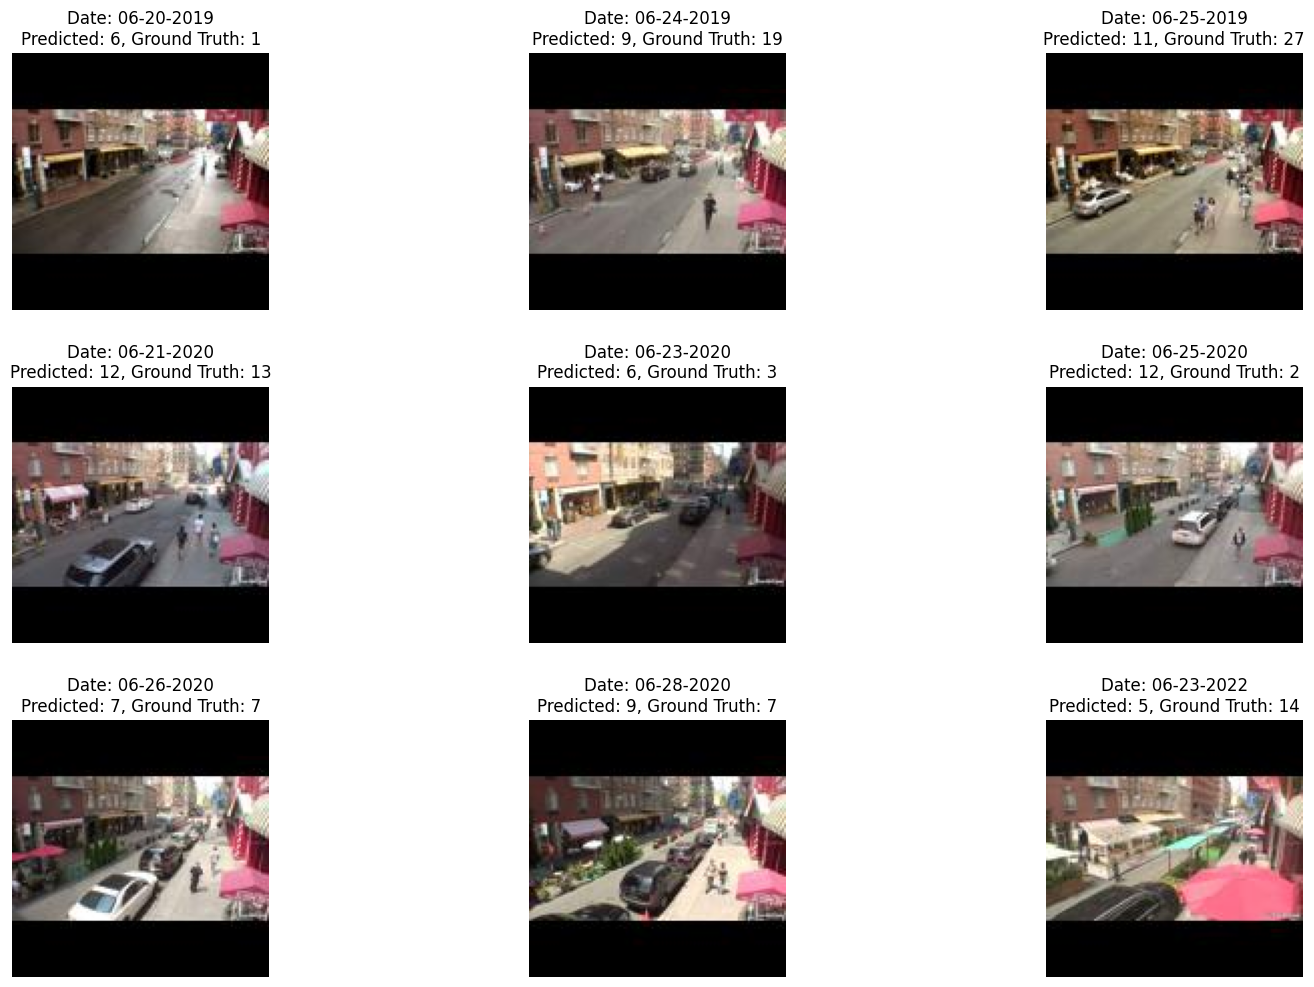

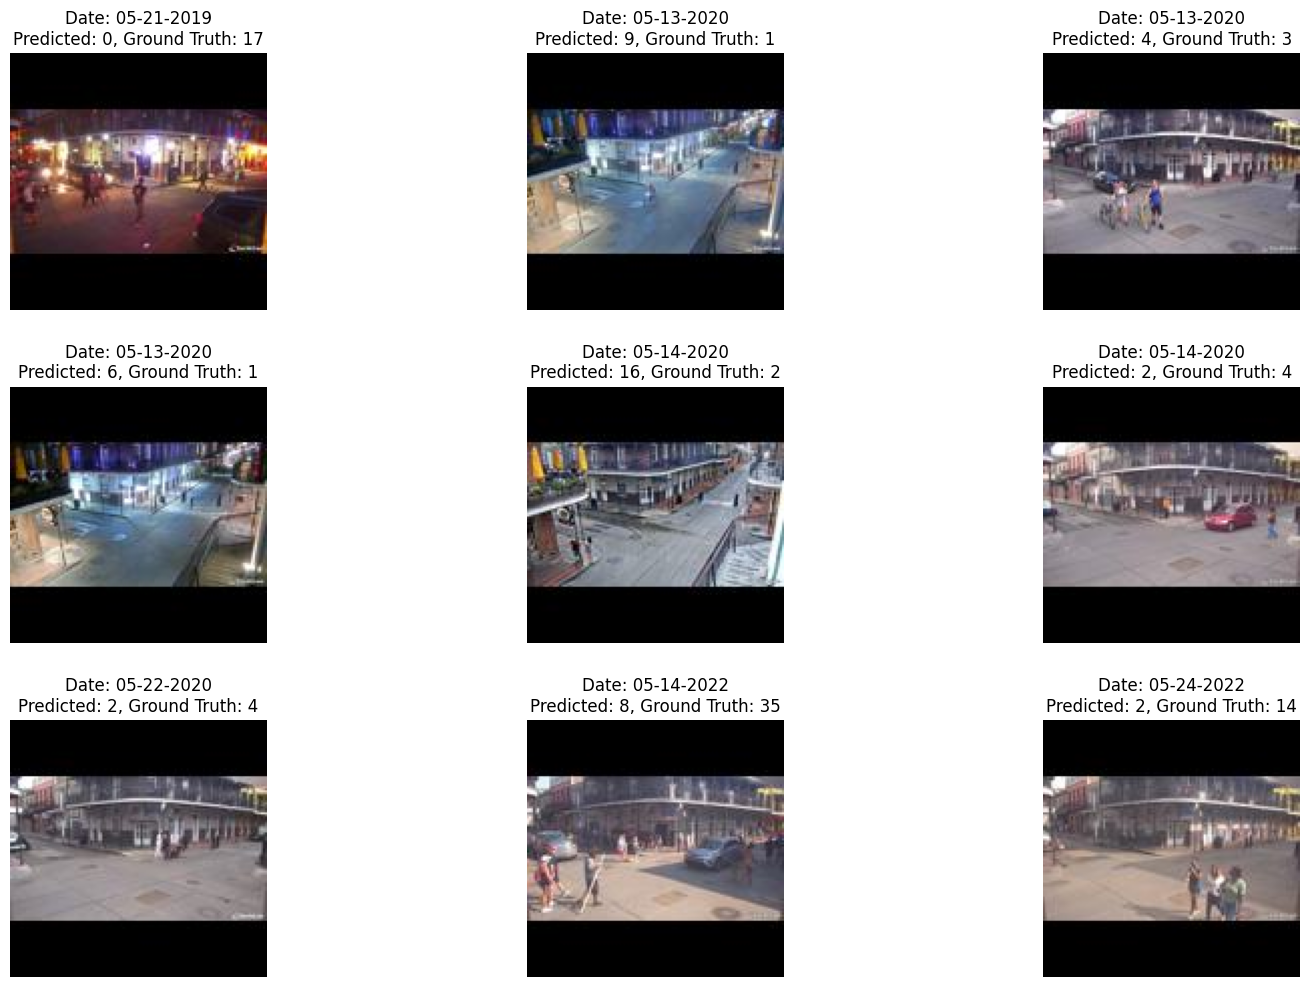

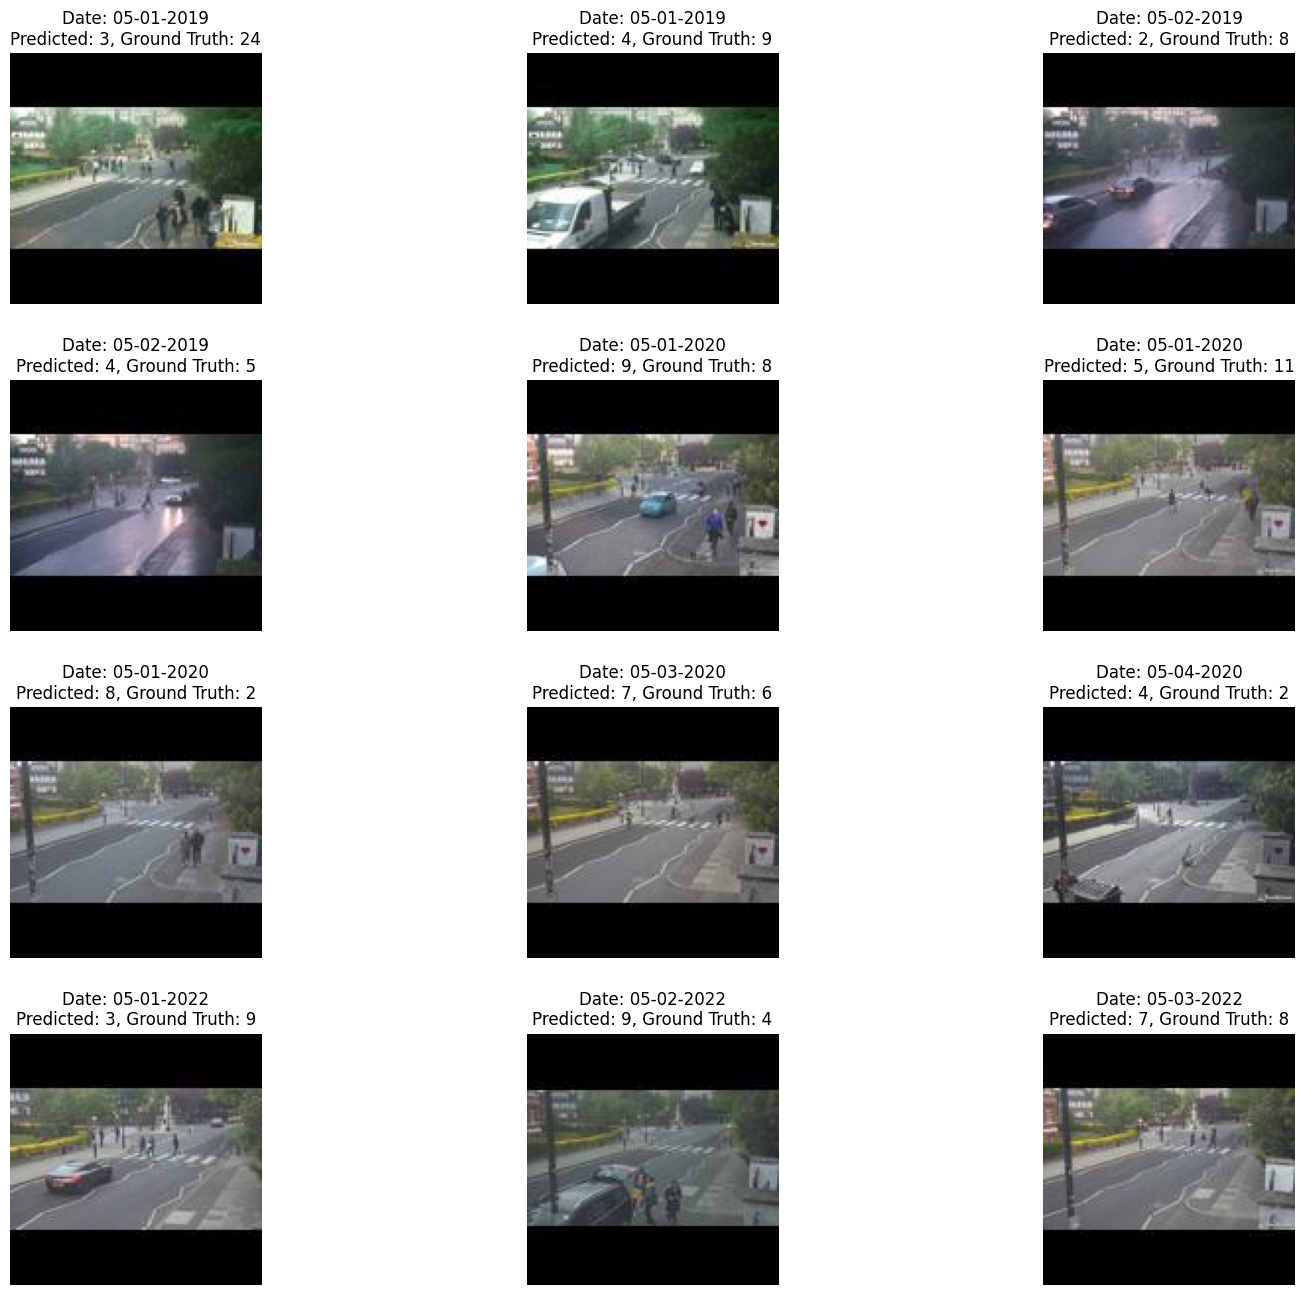

In [34]:
all_predictions = {}

ground_truth_csv_paths = {
    'New York': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_York_filtered.csv',
    'New Orleans': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_Orleans_filtered.csv',
    'London': '/content/drive/My Drive/Manual_Annotations/ground_truth_London_filtered.csv'
}

for city, path in ground_truth_csv_paths.items():
  visualize_ground_truth_predictions(yolo, path, city, all_predictions)

## Performance Metrics

In [36]:
# Extract ground truth and predicted values
ground_truths = [data['ground_truth'] for data in all_predictions.values()]
predictions = [data['predicted'] for data in all_predictions.values()]

# Calculate MAE, MSE, RMSE
mae = np.mean(np.abs(np.array(ground_truths) - np.array(predictions)))
mse = np.mean((np.array(ground_truths) - np.array(predictions)) ** 2)
rmse = np.sqrt(mse)

print("MAE", mae)
print("MSE", mse)
print("RMSE", rmse)

MAE 6.833333333333333
MSE 89.16666666666667
RMSE 9.44281031614353
